In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)


# Load Data

In [4]:
crashes = pd.read_csv("/Users/garrettpinkston/Desktop/Michigan/STAT504/Reports/Report4/Data/Traffic_Crashes_-_Crashes_20251007.csv")

/var/folders/k6/jt73vds53h50yfyvznvj62nw0000gn/T/ipykernel_27726/2170312875.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  crashes = pd.read_csv("/Users/garrettpinkston/Desktop/Michigan/STAT504/Reports/Report4/Data/Traffic_Crashes_-_Crashes_20251007.csv")


In [5]:
df = crashes.copy()

# filter up to 9/30/25 inclusive
df["CRASH_DATE"] = pd.to_datetime(df["CRASH_DATE"], errors="coerce", format="%m/%d/%Y %I:%M:%S %p")


# using cutoff date
cutoff_date = pd.Timestamp("2025-09-30 23:59:59")
df = df[df["CRASH_DATE"] <= cutoff_date].copy()

In [6]:
print(list(df.columns))

['CRASH_RECORD_ID', 'CRASH_DATE_EST_I', 'CRASH_DATE', 'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO', 'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE', 'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS', 'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LATITUDE', 'LONGITUDE', 'LOCATION']


In [7]:
len(df)

989533

# Handle Unknown/Not Applicable as NA

In [8]:
# standardize primary and secondary causes
df["PRIM_CONTRIBUTORY_CAUSE"] = df["PRIM_CONTRIBUTORY_CAUSE"].astype(str).str.upper()
df["SEC_CONTRIBUTORY_CAUSE"] = df["SEC_CONTRIBUTORY_CAUSE"].astype(str).str.upper()

# list of unknown conditions
unknowns = ["UNKNOWN", "UNABLE TO DETERMINE", "NOT APPLICABLE", "NAN", "", np.nan]

# shift instances where primary causes is an unknown condition, but secondary cause is present
mask = df["PRIM_CONTRIBUTORY_CAUSE"].isin(unknowns)
df.loc[mask, "PRIM_CONTRIBUTORY_CAUSE"] = df.loc[mask, "SEC_CONTRIBUTORY_CAUSE"]


In [9]:
# now filter out where primary causes is still blank
df = df[
    (~df["PRIM_CONTRIBUTORY_CAUSE"].isin(unknowns))
].copy()

In [10]:
len(df)

559874

# Map Causes

In [11]:

# List of cause mappings (subject to change)

cause_mapping = {
    # 1.Sinage error

    "FAILING TO YIELD RIGHT-OF-WAY": "Ignoring Sign / Right-of-Way",
    "DISREGARDING STOP SIGN": "Ignoring Sign / Right-of-Way",
    "DISREGARDING YIELD SIGN": "Ignoring Sign / Right-of-Way",
    "DISREGARDING TRAFFIC SIGNALS": "Ignoring Sign / Right-of-Way",
    "DISREGARDING OTHER TRAFFIC SIGNS": "Ignoring Sign / Right-of-Way",
    "DISREGARDING ROAD MARKINGS": "Ignoring Sign / Right-of-Way",
    "TURNING RIGHT ON RED": "Ignoring Sign / Right-of-Way",

    # Manuever Error
    "IMPROPER BACKING": "Maneuvering",
    "IMPROPER LANE USAGE": "Maneuvering",
    "IMPROPER OVERTAKING/PASSING": "Maneuvering",
    "IMPROPER TURNING/NO SIGNAL": "Maneuvering",
    "DRIVING ON WRONG SIDE/WRONG WAY": "Maneuvering",

    # Aggressive
    "OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER": "Reckless",
    "PASSING STOPPED SCHOOL BUS": "Reckless",
    "DRIVING SKILLS/KNOWLEDGE/EXPERIENCE": "Reckless",
    "FOLLOWING TOO CLOSELY": "Reckless",



    # 2. Speed-Related
    "EXCEEDING AUTHORIZED SPEED LIMIT": "Speed Related",
    "EXCEEDING SAFE SPEED FOR CONDITIONS": "Speed Related",
    "FAILING TO REDUCE SPEED TO AVOID CRASH": "Speed Related",

    # 3. Impairment / Physical Condition
    "HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)": "Driver Impairment",
    "UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)": "Driver Impairment",
    "PHYSICAL CONDITION OF DRIVER": "Driver Impairment",

    # 4. Distraction
    "DISTRACTION - FROM INSIDE VEHICLE": "Distracted Driver",
    "DISTRACTION - FROM OUTSIDE VEHICLE": "Distracted Driver",
    "DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)": "Distracted Driver",
    "CELL PHONE USE OTHER THAN TEXTING": "Distracted Driver",
    "TEXTING": "Distracted Driver",

    # 5. Environmental / Roadway Conditions
    "WEATHER": "Environment / Road Conditions",
    "ROAD ENGINEERING/SURFACE/MARKING DEFECTS": "Environment / Road Conditions",
    "ROAD CONSTRUCTION/MAINTENANCE": "Environment / Road Conditions",
    "OBSTRUCTED CROSSWALKS": "Environment / Road Conditions",
    "RELATED TO BUS STOP": "Environment / Road Conditions",
    "VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)": "Environment / Road Conditions",
    "ANIMAL": "Environment / Road Conditions",
    "EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST": "Environment / Road Conditions",

    # 6. Vehicle-Related
    "EQUIPMENT - VEHICLE CONDITION": "Vehicle Malfunction",

    # Struck Bike
    "BICYCLE ADVANCING LEGALLY ON RED LIGHT": "Struck Legally Proceeding Bike",
    "MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT": "Struck Legally Proceeding Bike",
    
    # 7. Other / Unknown / Not Applicable
    "UNABLE TO DETERMINE": "Unknown",
    "NOT APPLICABLE": "Unknown",
    
}


In [12]:
cause_mapping_upper = {k.upper(): v for k, v in cause_mapping.items()}

# map primary causes to their groups
df["PRIM_CAUSE_GROUP"] = df["PRIM_CONTRIBUTORY_CAUSE"].map(cause_mapping_upper)
df["SEC_CAUSE_GROUP"] = df["SEC_CONTRIBUTORY_CAUSE"].map(cause_mapping_upper)

In [13]:
len(df)

559874

In [14]:
sum(df['SEC_CAUSE_GROUP'].isna())

0

In [15]:
list(df["SEC_CAUSE_GROUP"].unique())

['Maneuvering',
 'Unknown',
 'Driver Impairment',
 'Reckless',
 'Speed Related',
 'Environment / Road Conditions',
 'Vehicle Malfunction',
 'Ignoring Sign / Right-of-Way',
 'Distracted Driver',
 'Struck Legally Proceeding Bike']

# Crashes Initial Daily Distribution

/var/folders/k6/jt73vds53h50yfyvznvj62nw0000gn/T/ipykernel_27726/843792376.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['CRASH_DATE'] = pd.to_datetime(df['CRASH_DATE'], errors='coerce', infer_datetime_format=True)


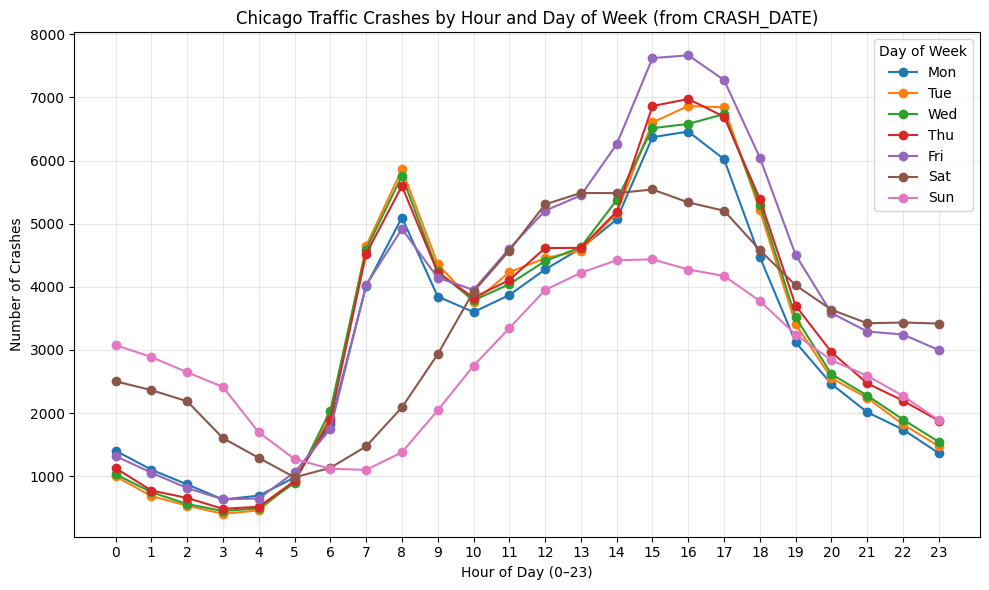

In [16]:
# --- Convert CRASH_DATE to datetime ---
df['CRASH_DATE'] = pd.to_datetime(df['CRASH_DATE'], errors='coerce', infer_datetime_format=True)

#extract hour
df['HOUR'] = df['CRASH_DATE'].dt.hour
df['DAY_OF_WEEK'] = df['CRASH_DATE'].dt.dayofweek + 1

df = df.dropna(subset=['HOUR', 'DAY_OF_WEEK'])

hourly = (
    df.groupby(['DAY_OF_WEEK', 'HOUR'])
      .size()
      .reset_index(name='COUNT')
)
pivot = hourly.pivot(index='HOUR', columns='DAY_OF_WEEK', values='COUNT').fillna(0)

# --- Plot (7 lines for 7 days) ---
plt.figure(figsize=(10, 6))
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

for dow in pivot.columns:
    plt.plot(pivot.index, pivot[dow], marker='o', label=day_labels[dow - 1])

plt.title("Chicago Traffic Crashes by Hour and Day of Week (from CRASH_DATE)")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Crashes")
plt.xticks(range(0, 24))
plt.legend(title="Day of Week")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Primary Causes

In [17]:
df_filtered = df.copy()

In [18]:
# replace unknown conditions in primary and secondary causes as nan
df_filtered[["PRIM_CONTRIBUTORY_CAUSE", "SEC_CONTRIBUTORY_CAUSE"]] = (
    df_filtered[["PRIM_CONTRIBUTORY_CAUSE", "SEC_CONTRIBUTORY_CAUSE"]]
    .replace(unknowns, np.nan)
)



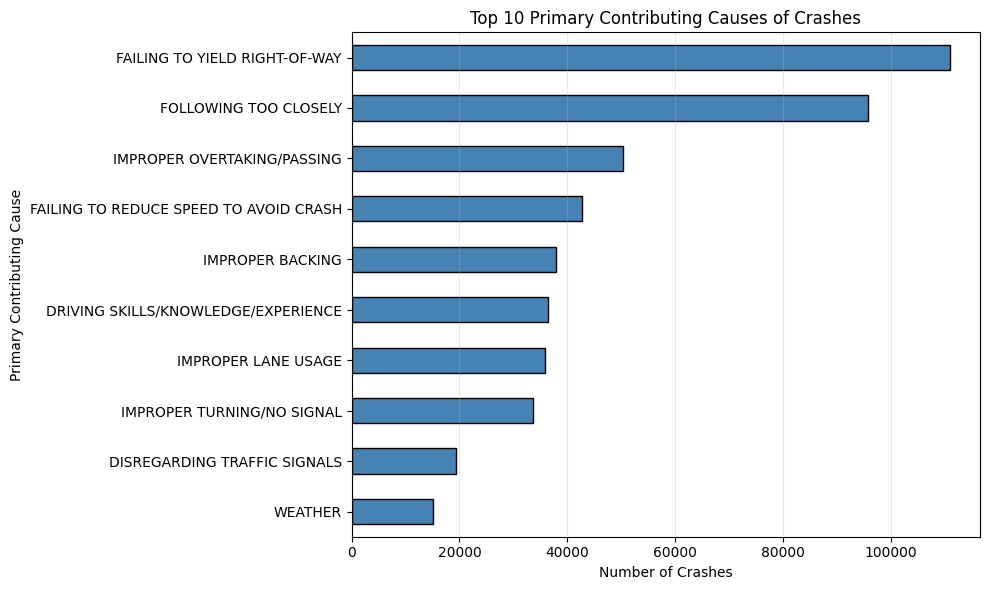

In [19]:
# top 10 causes

top_causes = (
    df_filtered["PRIM_CONTRIBUTORY_CAUSE"]
    .value_counts()
    .head(10)
    .sort_values(ascending=True)  # sort ascending for horizontal bars
)

# --- Plot ---
plt.figure(figsize=(10, 6))
top_causes.plot(kind="barh", color="steelblue", edgecolor="black")

plt.title("Top 10 Primary Contributing Causes of Crashes")
plt.xlabel("Number of Crashes")
plt.ylabel("Primary Contributing Cause")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

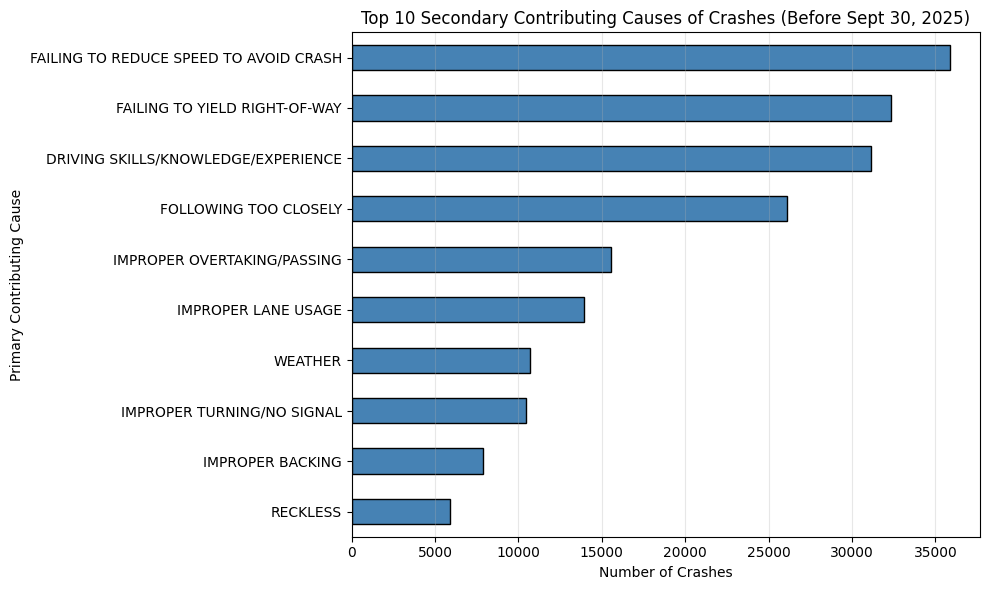

In [20]:
# top 10 causes for secondary

df_filtered.loc[
    df["SEC_CONTRIBUTORY_CAUSE"] == 
    "OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER",
    "SEC_CONTRIBUTORY_CAUSE"
] = "RECKLESS"

top_causes = (
    df_filtered["SEC_CONTRIBUTORY_CAUSE"]
    .value_counts()
    .head(10)
    .sort_values(ascending=True)  # sort ascending for horizontal bars
)

# --- Plot ---
plt.figure(figsize=(10, 6))
top_causes.plot(kind="barh", color="steelblue", edgecolor="black")

plt.title("Top 10 Secondary Contributing Causes of Crashes (Before Sept 30, 2025)")
plt.xlabel("Number of Crashes")
plt.ylabel("Primary Contributing Cause")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:

# Remove rows where primary and secondary causes are the same
df_filtered = df_filtered[
    df_filtered["PRIM_CONTRIBUTORY_CAUSE"] != df_filtered["SEC_CONTRIBUTORY_CAUSE"]
].copy()


df_filtered["PRIM_CONTRIBUTORY_CAUSE"] = df_filtered["PRIM_CONTRIBUTORY_CAUSE"].astype(str).str.upper()
df_filtered["SEC_CONTRIBUTORY_CAUSE"] = df_filtered["SEC_CONTRIBUTORY_CAUSE"].astype(str).str.upper()

# Treat these as missing
to_nan = ["UNABLE TO DETERMINE", "NOT APPLICABLE", "UNKNOWN", "OTHER", "NAN", ""]
df_filtered[["PRIM_CONTRIBUTORY_CAUSE", "SEC_CONTRIBUTORY_CAUSE"]] = (
    df_filtered[["PRIM_CONTRIBUTORY_CAUSE", "SEC_CONTRIBUTORY_CAUSE"]].replace(to_nan, np.nan)
)

# Top 10 primary causes
top_primary = df_filtered["PRIM_CONTRIBUTORY_CAUSE"].value_counts().head(10).index

# Keep only those, drop rows where secondary is NaN or same as primary
df_top = df_filtered[df_filtered["PRIM_CONTRIBUTORY_CAUSE"].isin(top_primary)].copy()
df_top = df_top[
    df_top["SEC_CONTRIBUTORY_CAUSE"].notna() &
    (df_top["PRIM_CONTRIBUTORY_CAUSE"] != df_top["SEC_CONTRIBUTORY_CAUSE"])
]

# Count all primary-secondary pairs
pair_counts = (
    df_top.groupby(["PRIM_CONTRIBUTORY_CAUSE", "SEC_CONTRIBUTORY_CAUSE"])
    .size()
    .reset_index(name="Count")
)

# For each primary, keep the secondary with the max Count
result = (
    pair_counts.loc[pair_counts.groupby("PRIM_CONTRIBUTORY_CAUSE")["Count"].idxmax()]
    .sort_values("Count", ascending=False)
    .reset_index(drop=True)
)

result

,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,Count
0,FOLLOWING TOO CLOSELY,FAILING TO REDUCE SPEED TO AVOID CRASH,9441
1,FAILING TO YIELD RIGHT-OF-WAY,FAILING TO REDUCE SPEED TO AVOID CRASH,6568
2,FAILING TO REDUCE SPEED TO AVOID CRASH,FOLLOWING TOO CLOSELY,3891
3,IMPROPER TURNING/NO SIGNAL,FAILING TO YIELD RIGHT-OF-WAY,2967
4,IMPROPER OVERTAKING/PASSING,IMPROPER LANE USAGE,2623
5,DISREGARDING TRAFFIC SIGNALS,FAILING TO REDUCE SPEED TO AVOID CRASH,2293
6,IMPROPER BACKING,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,2113
7,"OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELE...",RECKLESS,1685
8,IMPROPER LANE USAGE,IMPROPER OVERTAKING/PASSING,1668
9,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,FAILING TO REDUCE SPEED TO AVOID CRASH,920


# Filter for Peak Hours

In [22]:
df_peak = df[
    (df["CRASH_DAY_OF_WEEK"].between(2, 6)) &
    (df["CRASH_HOUR"].isin([8, 15, 16, 17]))
].copy()

In [23]:
df_peak["CRASH_HOUR"].unique()

array([17, 16, 15,  8])

In [24]:
df_peak["PRIM_CONTRIBUTORY_CAUSE"].unique()

array(['FAILING TO YIELD RIGHT-OF-WAY', 'IMPROPER OVERTAKING/PASSING',
       'IMPROPER BACKING', 'DISREGARDING ROAD MARKINGS',
       'FOLLOWING TOO CLOSELY', 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE',
       'IMPROPER LANE USAGE', 'DISREGARDING STOP SIGN',
       'PHYSICAL CONDITION OF DRIVER',
       'FAILING TO REDUCE SPEED TO AVOID CRASH',
       'IMPROPER TURNING/NO SIGNAL',
       'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)',
       'PASSING STOPPED SCHOOL BUS', 'DISREGARDING TRAFFIC SIGNALS',
       'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER',
       'DISTRACTION - FROM OUTSIDE VEHICLE',
       'DRIVING ON WRONG SIDE/WRONG WAY', 'EQUIPMENT - VEHICLE CONDITION',
       'DISTRACTION - FROM INSIDE VEHICLE',
       'DISREGARDING OTHER TRAFFIC SIGNS',
       'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)',
       'TEXTING', 'WEATHER', 'CELL PHONE USE OTHER THAN TEXTING',
       'HAD BEEN DRINKING (USE WHEN ARREST IS N

In [25]:

# Remove rows where primary and secondary causes are the same
peakdf_filtered = df_peak.copy()

peakdf_filtered = peakdf_filtered[
    peakdf_filtered["PRIM_CONTRIBUTORY_CAUSE"] != peakdf_filtered["SEC_CONTRIBUTORY_CAUSE"]
].copy()


peakdf_filtered["PRIM_CONTRIBUTORY_CAUSE"] = peakdf_filtered["PRIM_CONTRIBUTORY_CAUSE"].astype(str).str.upper()
peakdf_filtered["SEC_CONTRIBUTORY_CAUSE"] = peakdf_filtered["SEC_CONTRIBUTORY_CAUSE"].astype(str).str.upper()

# Treat these as missing
to_nan = ["UNABLE TO DETERMINE", "NOT APPLICABLE", "UNKNOWN", "OTHER", "NAN", ""]
peakdf_filtered[["PRIM_CONTRIBUTORY_CAUSE", "SEC_CONTRIBUTORY_CAUSE"]] = (
    peakdf_filtered[["PRIM_CONTRIBUTORY_CAUSE", "SEC_CONTRIBUTORY_CAUSE"]].replace(to_nan, np.nan)
)

# Top 10 primary causes
top_primary = peakdf_filtered["PRIM_CONTRIBUTORY_CAUSE"].value_counts().head(10).index

# Keep only those, drop rows where secondary is NaN or same as primary
df_top = peakdf_filtered[peakdf_filtered["PRIM_CONTRIBUTORY_CAUSE"].isin(top_primary)].copy()
df_top = df_top[
    df_top["SEC_CONTRIBUTORY_CAUSE"].notna() &
    (df_top["PRIM_CONTRIBUTORY_CAUSE"] != df_top["SEC_CONTRIBUTORY_CAUSE"])
]

# Count all primary-secondary pairs
pair_counts = (
    df_top.groupby(["PRIM_CONTRIBUTORY_CAUSE", "SEC_CONTRIBUTORY_CAUSE"])
    .size()
    .reset_index(name="Count")
)

# For each primary, keep the secondary with the max Count
result = (
    pair_counts.loc[pair_counts.groupby("PRIM_CONTRIBUTORY_CAUSE")["Count"].idxmax()]
    .sort_values("Count", ascending=False)
    .reset_index(drop=True)
)

result

,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,Count
0,FOLLOWING TOO CLOSELY,FAILING TO REDUCE SPEED TO AVOID CRASH,2485
1,FAILING TO YIELD RIGHT-OF-WAY,FAILING TO REDUCE SPEED TO AVOID CRASH,1694
2,FAILING TO REDUCE SPEED TO AVOID CRASH,FOLLOWING TOO CLOSELY,964
3,IMPROPER TURNING/NO SIGNAL,FAILING TO YIELD RIGHT-OF-WAY,677
4,IMPROPER OVERTAKING/PASSING,IMPROPER LANE USAGE,646
5,IMPROPER LANE USAGE,IMPROPER OVERTAKING/PASSING,437
6,IMPROPER BACKING,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,433
7,DISREGARDING TRAFFIC SIGNALS,FAILING TO REDUCE SPEED TO AVOID CRASH,290
8,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,FAILING TO REDUCE SPEED TO AVOID CRASH,175
9,WEATHER,FOLLOWING TOO CLOSELY,142


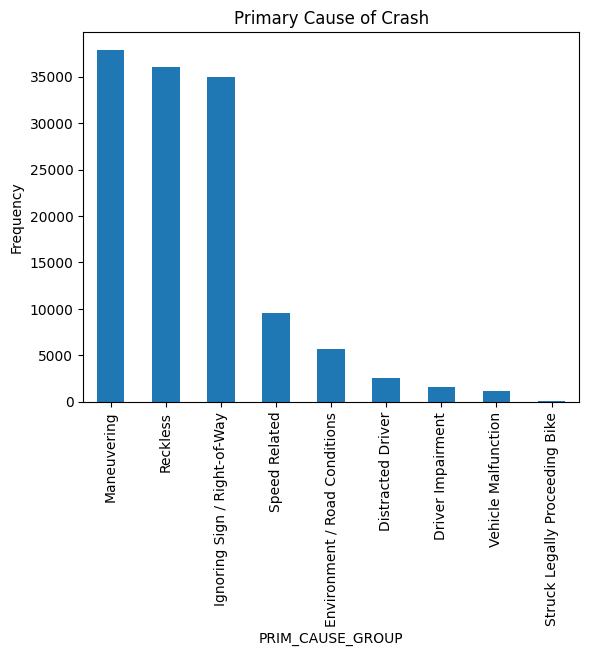

In [26]:
cause_counts = df_peak['PRIM_CAUSE_GROUP'].value_counts().sort_values(ascending=False)
cause_counts.plot.bar()

plt.title('Primary Cause of Crash')
plt.ylabel('Frequency')
plt.show()


In [27]:
freq_table = (
    df_peak["PRIM_CAUSE_GROUP"]
    .dropna()
    .value_counts()
    .reset_index()
)
freq_table.columns = ["Primary Contributing Cause", "Count"]
total = freq_table["Count"].sum()
freq_table["Percent"] = (freq_table["Count"] / total * 100).round(2)
freq_table.head(10)


,Primary Contributing Cause,Count,Percent
0,Maneuvering,37877,29.29
1,Reckless,36015,27.85
2,Ignoring Sign / Right-of-Way,34912,26.99
3,Speed Related,9549,7.38
4,Environment / Road Conditions,5665,4.38
5,Distracted Driver,2536,1.96
6,Driver Impairment,1566,1.21
7,Vehicle Malfunction,1174,0.91
8,Struck Legally Proceeding Bike,40,0.03


<Axes: xlabel='SEC_CAUSE_GROUP', ylabel='PRIM_CAUSE_GROUP'>

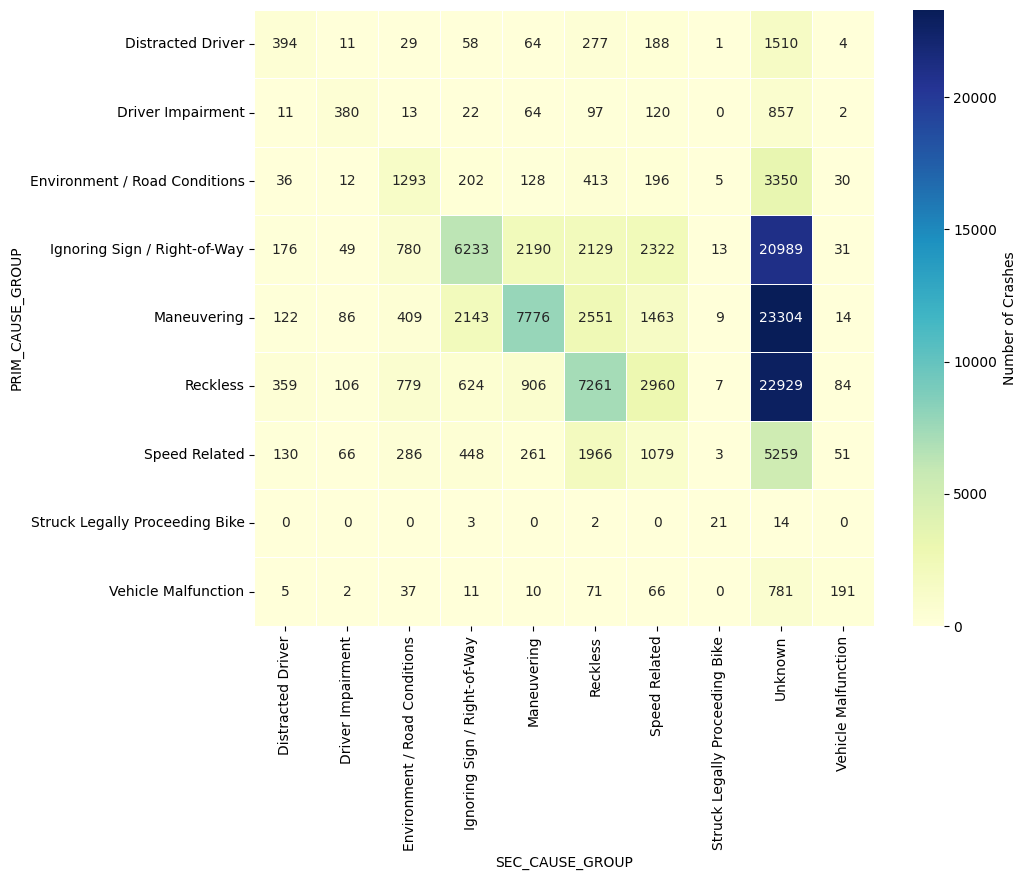

In [28]:
import seaborn as sns

heatmap_data = pd.crosstab(
    df_peak["PRIM_CAUSE_GROUP"],
    df_peak["SEC_CAUSE_GROUP"]
)

# --- Plot heatmap ---
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data,
    cmap="YlGnBu",
    annot=True,
    fmt=".0f",
    linewidths=0.5,
    cbar_kws={"label": "Number of Crashes"}
)